In [24]:
import os
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [25]:
# Carregar os dados de um diretório
directory = "C:/Users/Lucas Teixeira/AP-Emulators/Generated_Data_100K/ModelA"  # Substitua pelo seu diretório
Ns = 10000  # Número máximo de amostras a carregar
X = pd.read_csv(os.path.join(directory, "X.csv")).iloc[0:Ns]
Y = pd.read_csv(os.path.join(directory, "Y.csv")).iloc[0:Ns]
print(f"Carregado X com forma: {X.shape}")
print(f"Carregado Y com forma: {Y.shape}")

# Dividir os dados em treino e validação
test_size = 0.5
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)
print(f"Treino X: {X_train.shape}, Validação X: {X_val.shape}")
print(f"Treino Y: {Y_train.shape}, Validação Y: {Y_val.shape}")

Carregado X com forma: (10000, 3)
Carregado Y com forma: (10000, 5)
Treino X: (5000, 3), Validação X: (5000, 3)
Treino Y: (5000, 5), Validação Y: (5000, 5)


In [26]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  # Convert X_train to tensor
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32)  # Convert Y_train to tensor

# Now define the MultitaskGPModel and the likelihood
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, Y_train, likelihood):
        super(MultitaskGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=5
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=5, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [48]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=5)
model = MultitaskGPModel(X_train_tensor, Y_train_tensor, likelihood)

In [28]:
# Define the number of iterations for training
training_iterations = 10

# Set model and likelihood to training mode
model.train()
likelihood.train()

# Initialize the Adam optimizer (this includes model and likelihood parameters)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# Define the Marginal Log Likelihood (MLL) loss function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Start the training loop
for i in range(training_iterations):
    optimizer.zero_grad()  # Zero the gradients before backpropagation
    
    # Perform a forward pass of the model (get the output)
    output = model(X_train_tensor)
    
    # Compute the negative marginal log likelihood loss
    loss = -mll(output, Y_train_tensor)
    
    # Perform backpropagation to compute gradients
    loss.backward()
    
    # Print the loss every iteration
    print(f'Iter {i + 1}/{training_iterations} - Loss: {loss.item():.3f}')
    
    # Step the optimizer (update model parameters)
    optimizer.step()


Iter 1/10 - Loss: 4.859
Iter 2/10 - Loss: 4.446
Iter 3/10 - Loss: 4.067
Iter 4/10 - Loss: 3.720
Iter 5/10 - Loss: 3.414
Iter 6/10 - Loss: 3.147
Iter 7/10 - Loss: 2.915
Iter 8/10 - Loss: 2.712
Iter 9/10 - Loss: 2.531
Iter 10/10 - Loss: 2.368


c:\Users\Lucas Teixeira\anaconda3\envs\ap_emulator\Lib\site-packages\gpytorch\distributions\multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


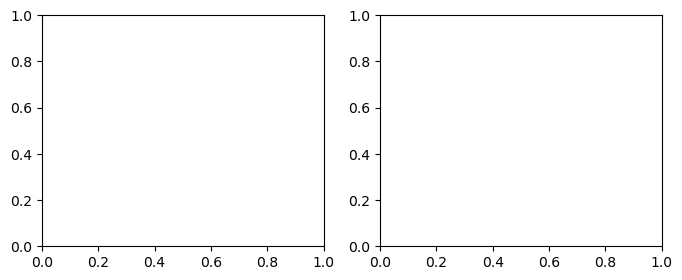

In [49]:
# Convert X_val and Y_val to tensors
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)  # Convert DataFrame to tensor
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.float32)  # Convert DataFrame to tensor

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_val_tensor))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

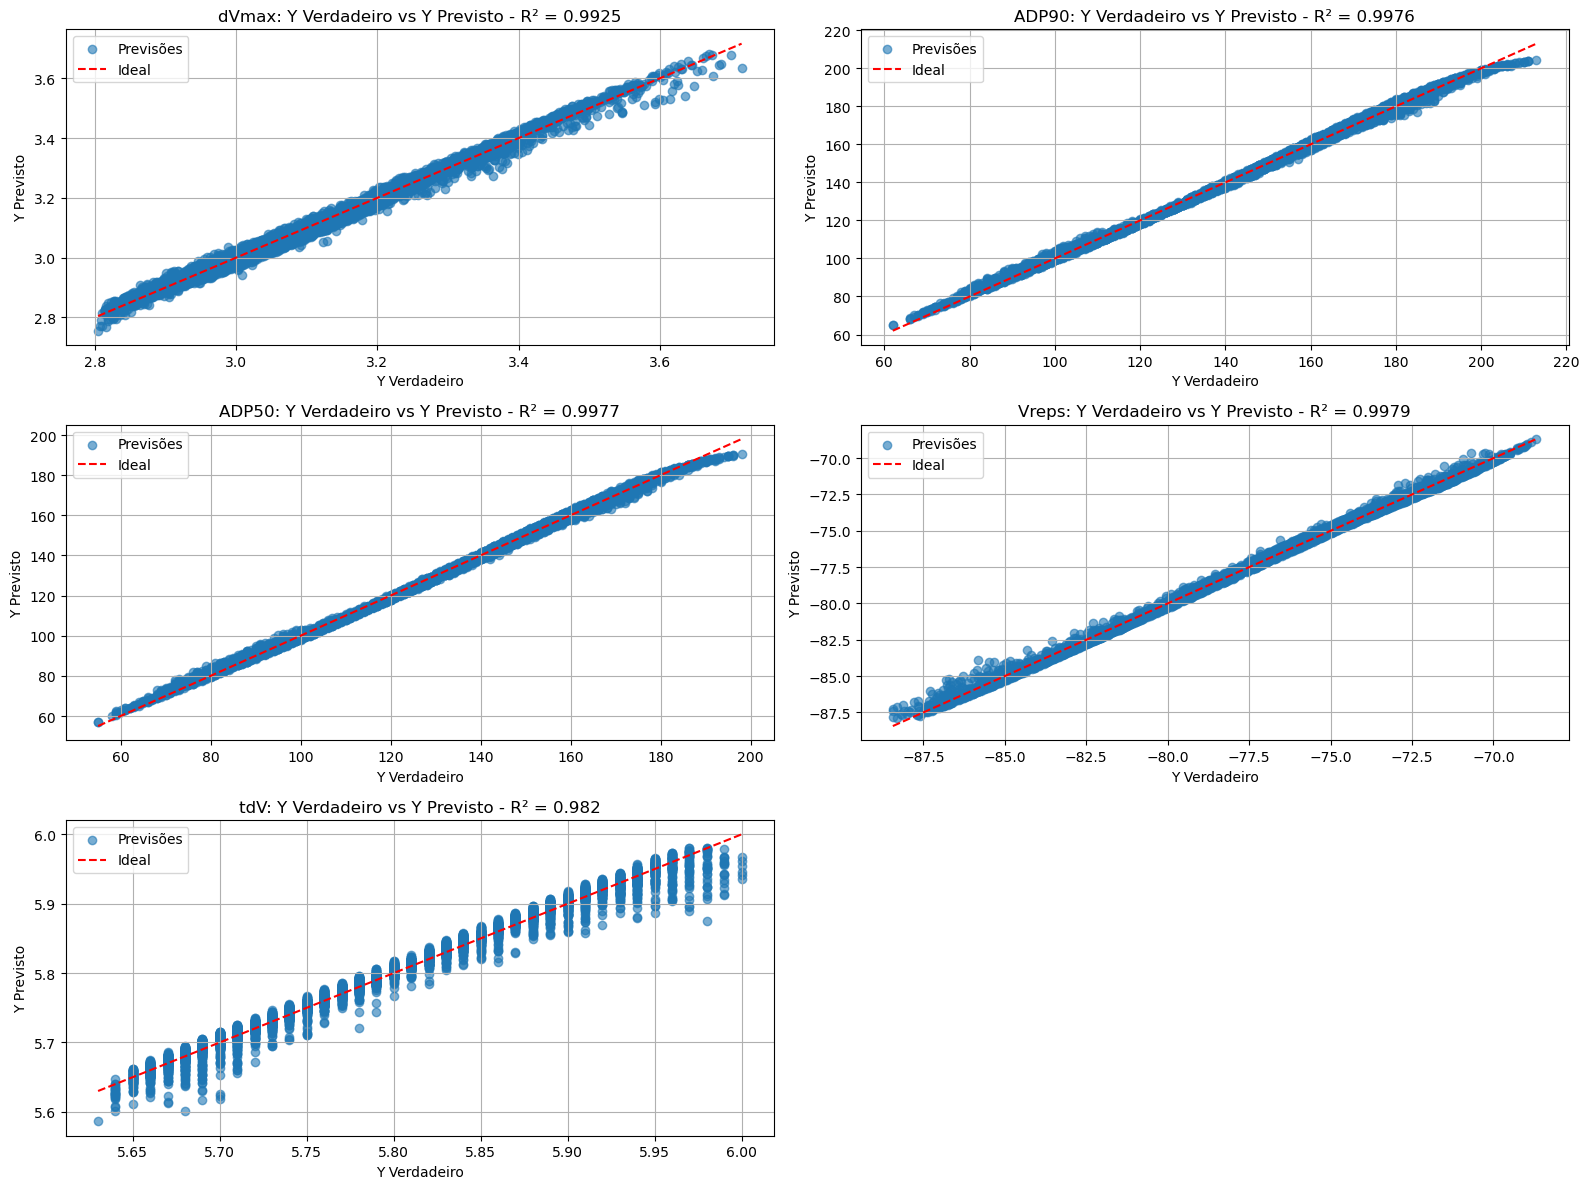

In [46]:
# Plotar Y verdadeiro vs Y previsto para cada QoI
# Configurar layout do mega plot

num_qois = len(Y.columns)
rows = 3
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
axes = axes.flatten()

for i, qoi in enumerate(Y.columns):
    ax = axes[i]
    ax.scatter(Y_val_tensor[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)], alpha=0.6, label="Previsões")
    ax.plot([Y_val_tensor[:, i].numpy().min(), Y_val_tensor[:, i].numpy().max()], [Y_val_tensor[:, i].numpy().min(), Y_val_tensor[:, i].numpy().max()], 
            color="red", linestyle="--", label="Ideal")
    r2 = r2_score(Y_val_tensor[:, i].numpy(), mean[:, Y.columns.get_loc(qoi)])
    ax.set_title(f"{qoi}: Y Verdadeiro vs Y Previsto - R² = {round(r2,4)}")
    ax.set_xlabel("Y Verdadeiro")
    ax.set_ylabel("Y Previsto")
    ax.legend()
    ax.grid(True)

# Desativar eixos vazios, caso o número de QoIs seja menor que o total de subplots
for j in range(len(axes)):
    if j >= num_qois:
        axes[j].axis('off')

plt.tight_layout()
plt.savefig(f"{name}.jpg")